<a href="https://colab.research.google.com/github/Maxlab/pytorch_learn/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch import nn
from torch.optim import lr_scheduler
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [2]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 26.73 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                ])

transform_train = transforms.Compose([
                                      #transforms.RandomRotation(10),
    	                                #transforms.RandomResizedCrop(224),
                                      transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                               ])

training_dataset = datasets.ImageFolder('./ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('./ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

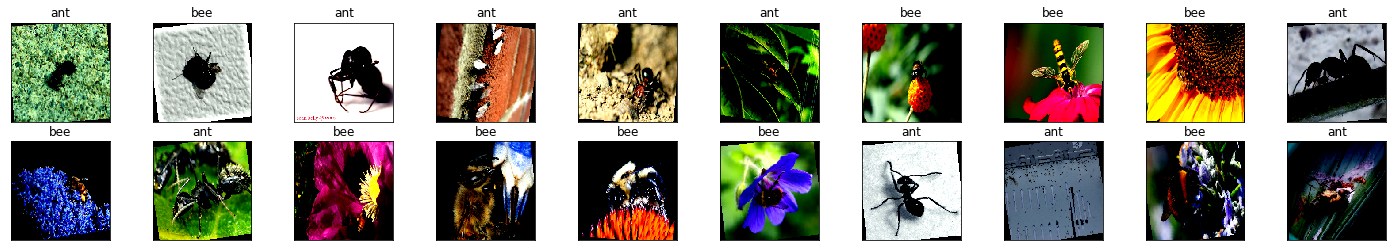

In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.225))
  image = image.clip(0, 1)
  return image

classes = ('ant', 'bee')

dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [5]:
model = models.resnet101(True)
model


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 100MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
for name, child in model.named_children():
  print(name)

for name, child in model.named_children():
   if name in ['fc']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

#for param in model.features.parameters():
  #param.required_grad = False

n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.fc = last_layer

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


In [8]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 5
loss_history = []
corrects_history = []
val_loss_history = []
val_corrects_history = []


for e in range(epochs):
  loss = .0
  corrects = .0
  val_loss = .0
  val_corrects = .0

  for inputs, labels in training_loader:
    model.train()
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  

    _, preds = torch.max(outputs, 1)
    loss += loss.item()
    corrects += torch.sum(preds == labels.data)
 
  else:
    model.eval()
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_loss += val_loss.item()
        val_corrects += torch.sum(val_preds == val_labels.data)
    
    count_tl = len(training_loader.dataset)
    epoch_loss = loss / count_tl
    epoch_acc  = corrects.float() / count_tl
    loss_history.append(epoch_loss)
    corrects_history.append(epoch_acc)

    val_epoch_loss = val_loss / len(validation_loader.dataset)
    val_epoch_acc  = val_corrects.float() / len(validation_loader.dataset)
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)


    print("Epoch: {}  Count_TrainLoader: {}  TrainAccrsy: {:.4f}  ValAccrsy: {:.4f}".format(e+1, count_tl, epoch_acc, val_epoch_acc))

Epoch: 1  Count_TrainLoader: 244  TrainAccrsy: 0.5574  ValAccrsy: 0.5621
Epoch: 2  Count_TrainLoader: 244  TrainAccrsy: 0.8197  ValAccrsy: 0.8954
Epoch: 3  Count_TrainLoader: 244  TrainAccrsy: 0.9057  ValAccrsy: 0.9150
Epoch: 4  Count_TrainLoader: 244  TrainAccrsy: 0.9303  ValAccrsy: 0.9085
Epoch: 5  Count_TrainLoader: 244  TrainAccrsy: 0.9385  ValAccrsy: 0.9216


In [0]:
import PIL.ImageOps
import requests
from PIL import Image

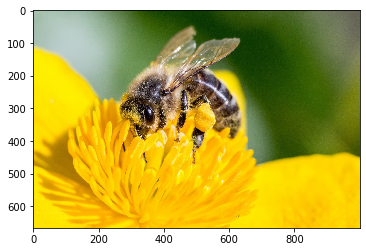

In [11]:
url = 'https://www.scienceabc.com/wp-content/uploads/2017/11/Honey-bee.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

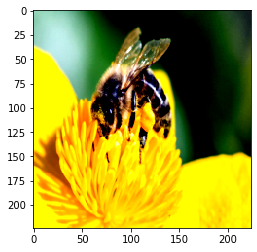

In [12]:
img = transform(img) 
plt.imshow(im_convert(img))

In [13]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


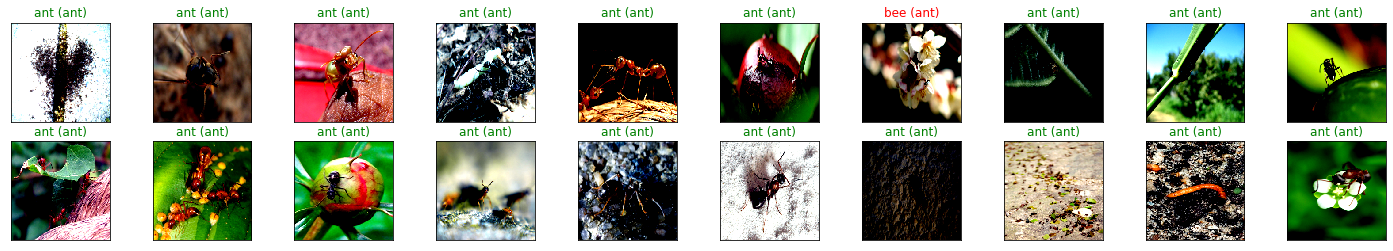

In [14]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))